# Video pipeline with Yolo + Resnet Model

In [19]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative
import experiments.utils.drawing

In [20]:
serieses = [700, 701, 702, 703, 704]
series_metadata = {
    700: {"label": "IPA"},
    701: {"label": "FA2-low"},
    702: {"label": "FA2-high"},
    703: {"label": "RIM-low"},
    704: {"label": "RIM-high"},
}
pipeline_name = "sum-qa"

series_paths = {
    series: os.path.join(FINAL_RESULTS_PATH, "series", str(series))
    for series in serieses
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [21]:
loaders

{700: <experiments.utils.parser.AdaptationParser at 0x7f992dd6ad60>,
 701: <experiments.utils.parser.AdaptationParser at 0x7f992d96da90>,
 702: <experiments.utils.parser.AdaptationParser at 0x7f992d85d850>,
 703: <experiments.utils.parser.AdaptationParser at 0x7f992e000d30>,
 704: <experiments.utils.parser.AdaptationParser at 0x7f992d8088e0>}

In [22]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 700 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 10,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': None,
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 0.5,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 5,
    'gamma': 10,
    'initial_active_model': [   'sshleifer-distilbart-xsum-1-1',
                                'deepset-roberta-base-squad2'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 0,
    'logs_enabled': False,
    'metadata': 'bursty - ipa - cpu type: compute_cascadelake_r_ib',
    'mode': 'exponential',
    'model_name': ['nlp-sum', 'nlp-qa'],
    'monitoring_duration': 2,
    'nodes': [   {   'cpu_request': '2',
                     'data_type': 'text',
                     'max_batch_size': '1',
          

In [23]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [24]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{700: False, 701: False, 702: False, 703: False, 704: False}

In [25]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [26]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Comparing Predicted Load with the Recieved Load

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

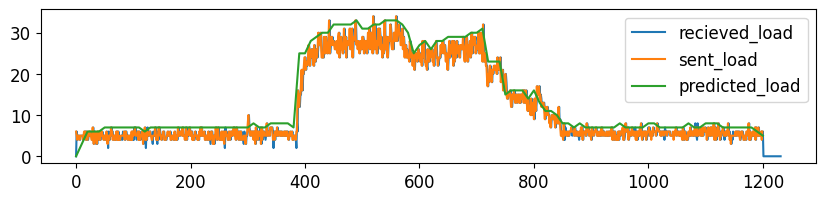

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

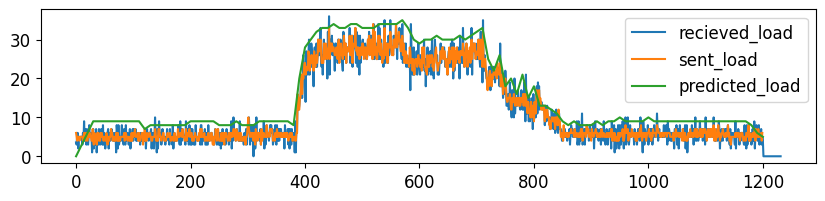

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

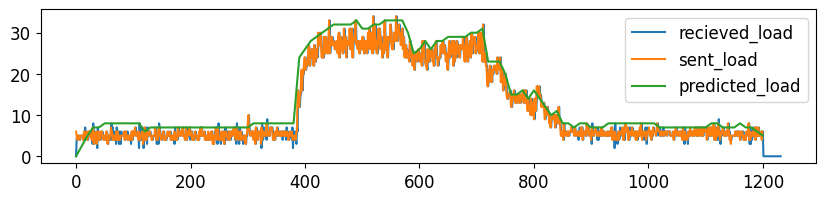

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

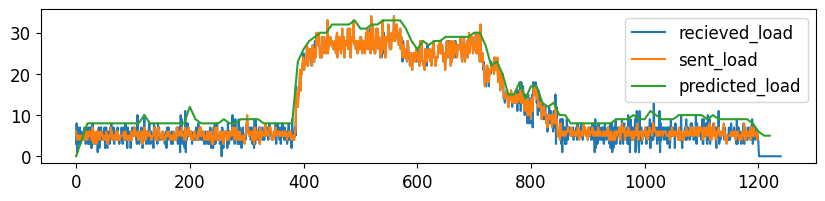

[6, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 4, 6, 5, 4, 5, 6, 5, 6, 5, 5, 4, 4, 7, 4, 3, 6, 5, 4, 4, 3, 6, 4, 6, 5, 4, 4, 6, 5, 6, 5, 5, 4, 5, 5, 4, 4, 6, 5, 3, 5, 5, 4, 5, 5, 7, 6, 6, 4, 5, 5, 4, 5, 4, 6, 6, 4, 6, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 4, 6, 6, 5, 5, 4, 5, 5, 4, 5, 4, 4, 6, 4, 6, 5, 6, 6, 7, 5, 5, 5, 5, 6, 4, 6, 4, 4, 5, 5, 6, 6, 3, 5, 5, 7, 4, 5, 4, 6, 5, 5, 5, 6, 6, 5, 5, 4, 4, 5, 5, 5, 5, 7, 6, 4, 4, 5, 4, 7, 7, 6, 5, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 5, 4, 5, 4, 5, 7, 5, 5, 5, 6, 6, 6, 5, 7, 5, 5, 5, 4, 5, 7, 4, 6, 5, 6, 6, 7, 5, 5, 6, 6, 4, 5, 4, 4, 5, 6, 5, 5, 5, 4, 5, 4, 6, 5, 7, 5, 7, 5, 5, 5, 5, 6, 4, 4, 5, 5, 4, 4, 6, 5, 4, 4, 5, 6, 6, 4, 3, 5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5,

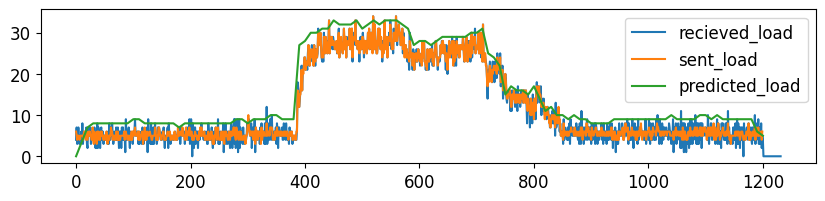

In [27]:
for series, series_dict in series_changes.items():
    recieved_load = series_changes[series]["recieved_load"]
    predicted_load = series_changes[series]["predicted_load"]
    # recieved_load = [int(item) for item in recieved_load if item != 0]
    recieved_load_x = [x for x in range(0, len(recieved_load))]
    sent_load_x = [x for x in range(0, len(sent_loads[series]))]
    predicted_load_x = series_changes[series]["time_interval"]

    print(sent_loads[series])
    print(recieved_load)

    print(len(sent_loads[series]))
    print(len(recieved_load))
    plt.figure(figsize=(10, 2))
    plt.plot(recieved_load_x, recieved_load, label="recieved_load")
    plt.plot(sent_load_x, sent_loads[series], label="sent_load")
    plt.plot(predicted_load_x, predicted_load, label="predicted_load")
    # TODO add predicted reference load here
    plt.legend()
    plt.show()

## Replica Changes
1. Total
2. Per node

In [28]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]

## Per Container Core changes
1. Total
2. Per Node

In [29]:
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

In [30]:
total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()
    # draw_temporal(total_core_changes[series])
ylabel = "Total Core"
print(total_core_changes)
print(total_core_changes.keys())
# print(total_core_changes[221].keys())

{700: {'nlp-sum': [2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 9, 10, 10, 11, 11, 11, 11, 11, 11, 12, 11, 11, 11, 11, 12, 12, 12, 11, 11, 9, 10, 10, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 8, 8, 8, 6, 6, 6, 6, 5, 6, 5, 4, 4, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], 'nlp-qa': [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 5, 5, 5, 3, 4, 4, 4, 3, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'total': [3.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0

## Accuracy Changes

In [31]:
accuracy_changes = {}
for series in serieses:
    accuracy_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        accuracy_changes[series][node_name] = metrics["accuracy"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    if accuracy_methods[series] == "sum":
        accuracy_changes[series]["e2e"] = [
            sum(x) for x in zip(*accuracy_changes[series].values())
        ]
ylabel = "Accuracy"
print(accuracy_changes)
print(accuracy_changes.keys())
# print(accuracy_changes[221].keys())

{700: {'nlp-sum': [0.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8], 'nlp-qa': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

## Maeseured p99 Latency


In [32]:
timeout_per_second = {}
per_second_results = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_per_second[series], per_second_results[series] = loaders[
            series
        ].per_second_result_processing()
    else:
        timeout_per_second[series], per_second_results[series] = None, None

In [33]:
metric = "p99"  # [min, max, p99]
metrics_all = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    if not simulation_modes[series]:
        metric_columns = list(
            filter(lambda col: metric in col, per_second_results[series].columns)
        )
        metrics_all[series] = per_second_results[series][metric_columns]
        # metrics_all[series][f"{metric}_e2e"] = metrics_all[series].sum(axis=1).to_list()
        metrics_all[series] = metrics_all[series].to_dict(orient="list")
        # draw_temporal(metrics_all[series])
ylabel = "Second"
print(metrics_all)
print(metrics_all.keys())
# print(metrics_all[221].keys())

{700: {'client_to_router_p99': [0.009072744846343994, 0.0038582897186279297, 0.004172201156616211, 0.004324712753295898, 0.004095649719238282, 0.004243621826171875, 0.0043970060348510745, 0.004374113082885742, 0.004132490158081054, 0.005687894821166992, 0.0046977710723876956, 0.004778976440429687, 0.004820022583007812, 0.004679107666015625, 0.004494702816009522, 0.0046030616760253905, 0.004374709129333496, 0.004501948356628418, 0.005375943183898925, 0.004683418273925781, 0.004795057773590088, 0.004637184143066406, 0.0054270863533020025, 0.0046939563751220706, 0.004737937450408935, 0.004503946304321289, 0.0050890731811523435, 0.004875366687774658, 0.004942679405212402, 0.005162768363952637, 0.0049479460716247555, 0.005083332061767578, 0.00570436716079712, 0.005097417831420898, 0.005088245868682862, 0.0051262426376342774, 0.005270962715148926, 0.0069529652595520025, 0.00502741813659668, 0.005232489109039307, 0.006040897369384766, 0.004800033569335937, 0.006070973873138427, 0.005141568183

## timeouts

In [34]:
ylabel = "% SLA Violations"
xlabel = "Experiments"
timeout_dics = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_dics[series] = {
            "e2e": (
                np.array(timeout_per_second[series]) / sum(sent_loads[series])
            ).tolist()
        }
        # draw_temporal(timeout_dics[series])
        print(f"{sum(timeout_per_second[series])} out of {sum(sent_loads[series])}")

print(timeout_dics)
print(timeout_dics.keys())
# print(timeout_dics[221].keys())

710 out of 14437
61 out of 14437
1243 out of 14437
12204 out of 14437
0 out of 14437
{700: {'e2e': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001385329362055829, 0.00020779940430837432, 0.0, 0.0001385329362055829, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

# Paper ready figures

In [35]:
import importlib
import math


METRIC_TOTAL_CORE_CHANGES = "cost"
METRIC_ACCURACY_CHANGES = "accuracy"
METRIC_MEASURED_LATENCY = "latency"
# METRIC_TIMEOUT_DICS = "sla_violation"


metrics_metadata = {
    METRIC_TOTAL_CORE_CHANGES: {
        "title": "Cost",
        "ylabel": "Cost (cores)",
    },
    METRIC_ACCURACY_CHANGES: {
        "title": "Accuracy",
        "ylabel": "Accuracy",
    },
    METRIC_MEASURED_LATENCY: {
        "title": "Latency",
        "ylabel": "Latency (s)",
    },
    # METRIC_TIMEOUT_DICS: {
    #     "title": "SLA Violations",
    #     "ylabel": "SLA Violations (%)",
    # },
}
results = {
    METRIC_MEASURED_LATENCY: {},
    # METRIC_TIMEOUT_DICS: {},
    METRIC_TOTAL_CORE_CHANGES: {},
    METRIC_ACCURACY_CHANGES: {},
}

# for serie in timeout_dics.keys():
#     sla_violations = list(filter(lambda x: x is not None and not math.isnan(x), timeout_dics[serie]["e2e"]))
#     results[METRIC_TIMEOUT_DICS][serie] = sum(sla_violations)/len(sla_violations)  # Fixme: Is this correct?

for serie in metrics_all.keys():
    latencies = list(
        filter(
            lambda x: x is not None and not math.isnan(x), metrics_all[serie]["e2e_p99"]
        )
    )
    results[METRIC_MEASURED_LATENCY][serie] = sum(latencies) / len(latencies)

for serie in accuracy_changes.keys():
    results[METRIC_ACCURACY_CHANGES][serie] = sum(accuracy_changes[serie]["e2e"]) / len(
        accuracy_changes[serie]["e2e"]
    )

for serie in total_core_changes.keys():
    results[METRIC_TOTAL_CORE_CHANGES][serie] = sum(
        total_core_changes[serie]["total"]
    ) / len(total_core_changes[serie]["total"])


print(results)

{'latency': {700: 1.1571602020154665, 701: 0.6776852426668002, 702: 1.0644188943106923, 703: 2.584989532248392, 704: 0.4186092241982613}, 'cost': {700: 16.725, 701: 9.575, 702: 57.13333333333333, 703: 13.926229508196721, 704: 20.0}, 'accuracy': {700: 1.4900000000000022, 701: 1.0, 702: 2.0, 703: 1.9491803278688542, 704: 1.0}}


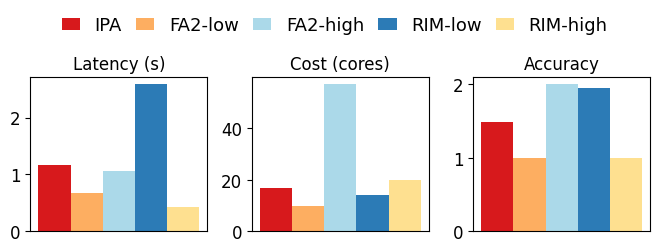

In [36]:
importlib.reload(experiments.utils.drawing)

experiments.utils.drawing.draw_cumulative_final(
    results, series_metadata, metrics_metadata, f"{pipeline_name}-cul"
)